In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import statsmodels as sm
from statsmodels.graphics import tsaplots

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error

import warnings
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('State_time_series_Final.csv')

In [3]:
data['Date'] = pd.to_datetime(data.Date)

In [4]:
df_ts = pd.DataFrame(zip(data['Date'], data['MedianListingPrice_AllHomes'],data['Sale_Prices'], data['Sale_Counts']),
        columns=['Date', 'MedianListingPrice_AllHomes','Sale_Prices', 'Sale_Counts'])

data_drop = df_ts.dropna(thresh=3)
data_drop.reset_index(drop = True)

,Date,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts
0,2012-01-31,149900.0,181050.0,2603.0
1,2012-01-31,229000.0,181050.0,5173.0
2,2012-01-31,207500.0,127100.0,9164.0
3,2012-01-31,139900.0,181050.0,1514.0
4,2012-01-31,207500.0,245000.0,27029.0
...,...,...,...,...
3667,2017-12-31,289000.0,181050.0,5173.0
3668,2017-12-31,349950.0,181050.0,5173.0
3669,2017-12-31,149900.0,181050.0,5173.0
3670,2017-12-31,189900.0,181050.0,5173.0


In [5]:
data_drop['Sales'] = df_ts['Sale_Prices']*df_ts['Sale_Counts']

In [6]:
data_drop.head(3)

,Date,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts,Sales
0,2012-01-31,149900.0,181050.0,2603.0,4.712732e+08
1,2012-01-31,229000.0,181050.0,5173.0,9.365716e+08
2,2012-01-31,207500.0,127100.0,9164.0,1.164744e+09


In [7]:
for col in df_ts.columns:
    # Determina si hay outliers para separarlos y poder imputar los valores faltantes de manera que no se vean afectados
    # por los valores atípicos
    if df_ts.loc[:,col].dtype!=object:

        Q1 = df_ts[col].quantile(0.25)
        Q3 = df_ts[col].quantile(0.75)
        IQR = Q3 - Q1
        BI = Q1 - 1.5*IQR
        BS = Q3 + 1.5*IQR

        out = (df_ts[col] < BI) | (df_ts[col] > BS)
    
    data_drop[col] = df_ts[col][~out]

In [8]:
len(df_ts.Date.unique())

72

In [9]:
data_month = data_drop.resample('M',on='Date').mean()
df_aux = data_month.reset_index()

df_ts = df_aux
df_ts['Date'] = df_aux['Date'].dt.to_period('M')
df_ts.set_index(['Date'],inplace = True)
df_ts.head()

,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts,Sales
Date,,,,
2012-01,186217.29,170674.0,4143.204082,8.290139e+08
2012-02,186866.94,169831.0,4202.816327,8.456398e+08
2012-03,189243.83,170393.0,4706.687500,1.039651e+09
2012-04,190602.20,171191.0,4788.916667,1.056214e+09
2012-05,190900.50,171174.0,5135.531915,1.216632e+09


In [10]:
diff_1 = df_aux['MedianListingPrice_AllHomes'].diff()
fo=list(diff_1)
df_aux['Diff_1_AllHomes_Price']=fo
df_aux

,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts,Sales,Diff_1_AllHomes_Price
Date,,,,,
2012-01,186217.290000,170674.000000,4143.204082,8.290139e+08,NaN
2012-02,186866.940000,169831.000000,4202.816327,8.456398e+08,649.650000
2012-03,189243.830000,170393.000000,4706.687500,1.039651e+09,2376.890000
2012-04,190602.200000,171191.000000,4788.916667,1.056214e+09,1358.370000
2012-05,190900.500000,171174.000000,5135.531915,1.216632e+09,298.300000
...,...,...,...,...,...
2017-08,241460.319149,198148.913043,7070.227273,2.392792e+09,-2041.446809
2017-09,239093.097826,199333.695652,7176.604167,2.035790e+09,-2367.221323
2017-10,238629.880435,200748.913043,7127.458333,2.068920e+09,-463.217391


<function matplotlib.pyplot.show(close=None, block=None)>

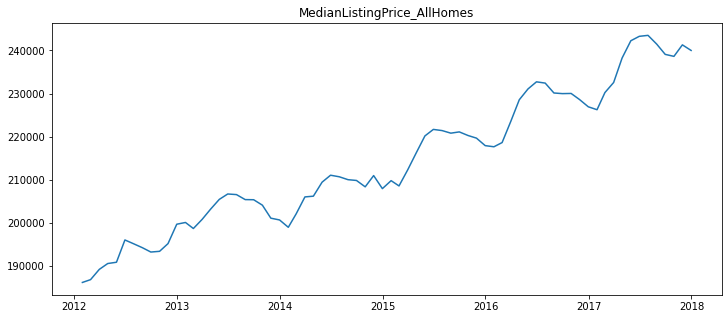

In [11]:
plt.figure(figsize=(12,5))
df_aux = data_month.reset_index()

plt.plot(df_aux.Date, df_aux.MedianListingPrice_AllHomes)
plt.title('MedianListingPrice_AllHomes')
plt.show

# - Test Dickey-fuller

In [12]:
from statsmodels.tsa.stattools import adfuller

print("Observations of Dickey-fuller test")
dftest = adfuller(df_aux.MedianListingPrice_AllHomes,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  0.442940
p-value                         0.983032
#lags used                      8.000000
number of observations used    63.000000
critical value (1%)            -3.538695
critical value (5%)            -2.908645
critical value (10%)           -2.591897
dtype: float64


Evidencia débil contra la hipótesis nula, lo cual significa que la serie de tiempo tiene una raíz unitaria que indica que no es estacionaria.

#### - Estacional de primer orden

In [13]:
from statsmodels.tsa.stattools import adfuller

print("Observations of Dickey-fuller test")
dftest = adfuller(diff_1.dropna(),autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                -6.680889e+00
p-value                        4.345243e-09
#lags used                     7.000000e+00
number of observations used    6.300000e+01
critical value (1%)           -3.538695e+00
critical value (5%)           -2.908645e+00
critical value (10%)          -2.591897e+00
dtype: float64


El valor de p es menor a 0.05, lo que significa que podemos recharzar la hipótesis nula H0. Podemos concluir que los datos no tienen raíz unitaria y son estacionarios.

### - Tendencia, Estacionalidad, Residuos

In [14]:
df_ts.index=df_ts.index.to_timestamp()
aux = seasonal_decompose(df_ts['MedianListingPrice_AllHomes'], model = "add")

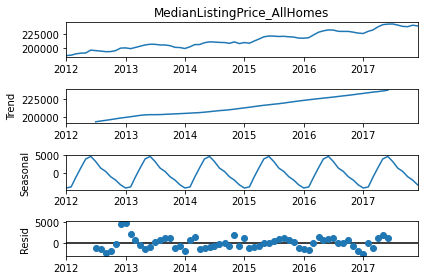

In [15]:
aux.plot();

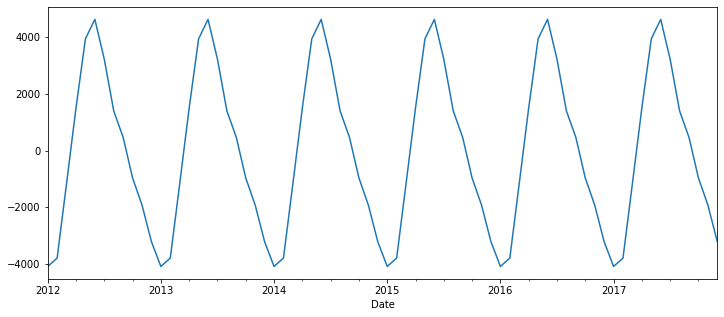

In [16]:
plt.figure(figsize = (12,5))
aux.seasonal.plot();

---

# - ARIMA

In [17]:
x = df_ts['MedianListingPrice_AllHomes'].diff().dropna()

### Correlogramas

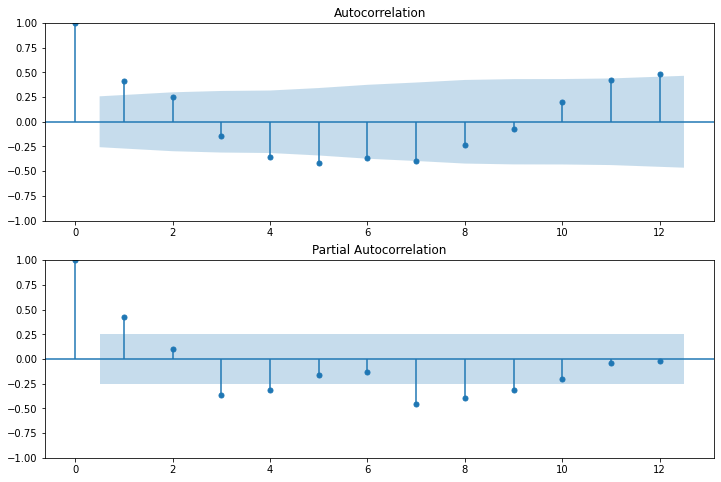

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(x.iloc[13:],lags=12,ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(x.iloc[13:],lags=12,ax=ax2)

### Datos: Train y Test

In [19]:
train = df_aux[0:int(len(df_aux)*.80)]
test = df_aux[int(len(df_aux)*.80):len(df_aux)]

size = len(df_aux) - 12
train, test = df_aux[0:size], df_aux[size:]

### Determinación de mejores parámetros 

In [20]:
arima_model =  auto_arima(train['MedianListingPrice_AllHomes'],start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 20 )
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1017.808, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1020.555, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1020.059, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1023.316, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1021.658, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.077 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -506.904
Date:                Sun, 04 Dec 2022   AIC                           1017.808
Time:                        12:11:41   BIC                           1021.858
Sample:                             0   HQIC                          1019.378
                                 - 57                                       

### Entrenamiento del modelo

In [21]:
from statsmodels.tsa.arima.model import ARIMA

In [22]:
model = ARIMA(train['MedianListingPrice_AllHomes'], order=(0,1,0))
arima_fit = model.fit()

In [23]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:     MedianListingPrice_AllHomes   No. Observations:                   57
Model:                          ARIMA(0, 1, 0)   Log Likelihood                -510.658
Date:                         Sun, 04 Dec 2022   AIC                           1023.316
Time:                                 12:11:41   BIC                           1025.341
Sample:                                      0   HQIC                          1024.101
                                          - 57                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       4.79e+06   9.02e+05      5.311      0.000    3.02e+06    6.56e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.78   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.03   Prob(JB):                         0.27
Heteroskedasticity (H):               1.44   Skew:                             0.41
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
fc = arima_fit.forecast(len(test), alpha=0.05) 
fc_series = pd.Series(fc, index=test.index)

### Evaluación del modelo

In [25]:
MSE = mean_squared_error(test['MedianListingPrice_AllHomes'], fc_series)
RMSE = np.sqrt(MSE)
print('MSE: ',MSE)
print('RMSE: ',RMSE)

MSE:  75053293.03754775
RMSE:  8663.3303664092


In [26]:
# MAPE: Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true)*100)

In [27]:
mape_arima = mape(test['MedianListingPrice_AllHomes'], fc_series) 
print('MAPE: ',round(mape_arima,2),'%')

MAPE:  3.03 %


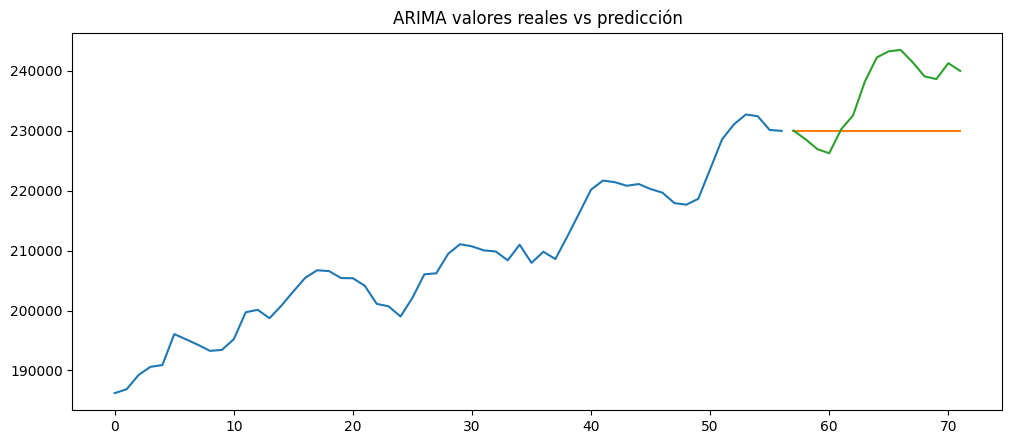

In [28]:
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['MedianListingPrice_AllHomes'], label='training')
plt.plot(fc_series, label='forecast')
plt.plot(test['MedianListingPrice_AllHomes'], label='actual')


plt.title('ARIMA valores reales vs predicción')
plt.show();

### Predicción

In [29]:
# Entreno el modelo con todos los datos
model = ARIMA(df_ts['MedianListingPrice_AllHomes'], order=(0,1,0))
arima_fit = model.fit()

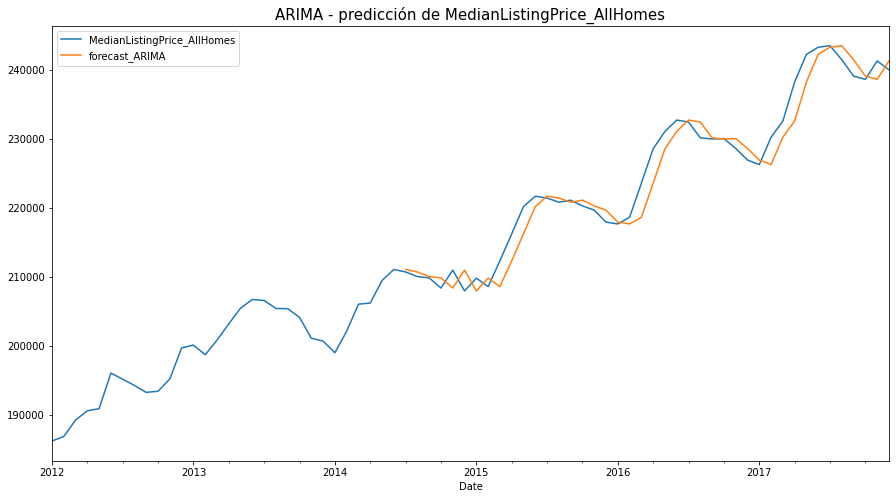

In [30]:
df_ts['forecast_ARIMA']=arima_fit.predict(start = 30, end = 156)
df_ts[['MedianListingPrice_AllHomes','forecast_ARIMA']].plot(figsize=(15,8))
plt.title('ARIMA - predicción de MedianListingPrice_AllHomes', fontsize = 15)
plt.show()

In [31]:
from pandas.tseries.offsets import DateOffset

future_arima = [df_ts.index[-1]+ DateOffset(months=x)for x in range(0,24)] # 2 años = 24 meses

In [32]:
future_df_ARIMA = pd.DataFrame(index=future_arima[1:],columns=df_ts.columns)

In [33]:
future_df = pd.concat([df_ts,future_df_ARIMA ]) # Concatenamos los dos dataframes

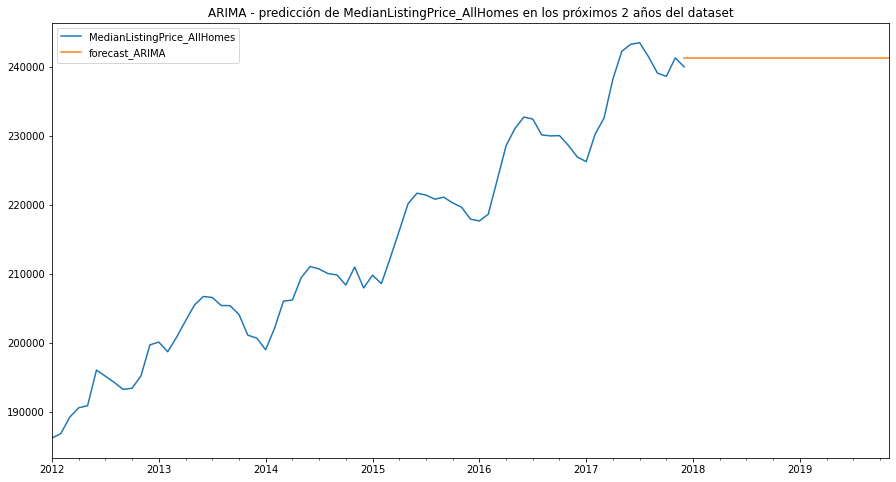

In [34]:
future_df['forecast_ARIMA'] = arima_fit.predict(start = 71, end = 156, dynamic= True)  
future_df[['MedianListingPrice_AllHomes', 'forecast_ARIMA']].plot(figsize=(15, 8)) 
plt.title('ARIMA - predicción de MedianListingPrice_AllHomes en los próximos 2 años del dataset')
plt.show()

---

## - SARIMA

### Datos: Train y Test

In [35]:
train = df_aux[0:int(len(df_aux)*.80)]
test = df_aux[int(len(df_aux)*.80):len(df_aux)]

### Determinación de mejores parámetros 

In [36]:
sarima_model =  auto_arima(train['MedianListingPrice_AllHomes'],start_p=0, d=1, start_q=0, 
                          max_p=6, max_d=6, max_q=6, start_P=0, 
                          D=1, start_Q=0, max_P=6, max_D=6,
                          max_Q=6, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 20 )
print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=806.315, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=809.402, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=809.448, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=815.489, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=808.073, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=807.630, Time=0.01 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=807.685, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=809.780, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=808.197, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.467 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(0, 1

### Entrenamiento del modelo

In [37]:
sarima_model = SARIMAX(train['MedianListingPrice_AllHomes'], order=(0,1,0),seasonal_order=(0,1,0,12))
sarima_fit = sarima_model.fit(disp=1)

In [38]:
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:        MedianListingPrice_AllHomes   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -402.157
Date:                            Sun, 04 Dec 2022   AIC                            806.315
Time:                                    12:11:42   BIC                            808.099
Sample:                                         0   HQIC                           806.976
                                             - 57                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       5.01e+06   9.76e+05      5.134      0.000     3.1e+06    6.92e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.44   Prob(JB):                         0.90
Heteroskedasticity (H):               0.27   Skew:                             0.01
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluación del modelo

In [39]:
sarima_fc_series = sarima_fit.forecast(len(test), alpha=0.05) 
MSE_sarima = mean_squared_error(test['MedianListingPrice_AllHomes'], sarima_fc_series)
RMSE_sarima = np.sqrt(MSE_sarima)

print('MSE:', MSE_sarima)
print('RMSE:', RMSE_sarima)

MSE: 4118626.9962368975
RMSE: 2029.4400696342077


In [40]:
mape_sarima = mape(test['MedianListingPrice_AllHomes'], sarima_fc_series) 
print('MAPE: ',round(mape_sarima,2),'%')

MAPE:  0.63 %


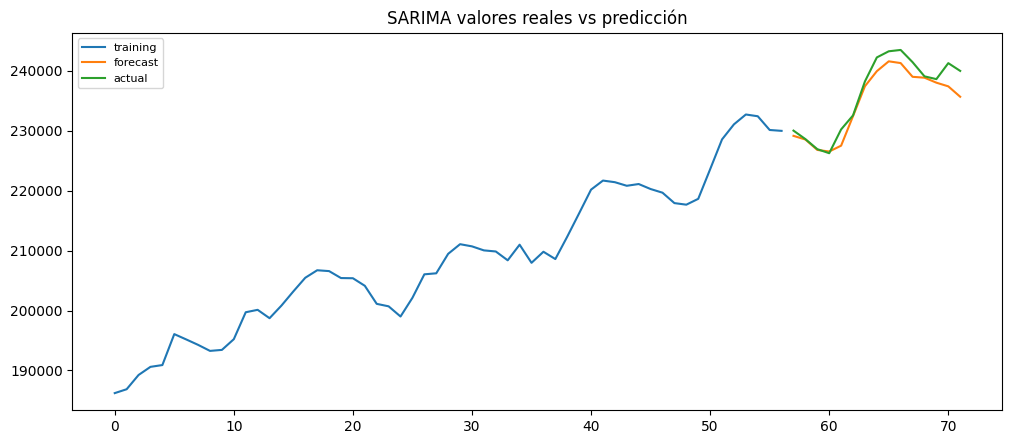

In [41]:
sarima_fc_series = pd.Series(sarima_fc_series, index=test.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['MedianListingPrice_AllHomes'], label='training')
plt.plot(sarima_fc_series, label='forecast')
plt.plot(test['MedianListingPrice_AllHomes'], label='actual')


plt.title('SARIMA valores reales vs predicción')
plt.legend(loc='upper left', fontsize=8);

### Predicción

In [42]:
sarima_model = sm.tsa.statespace.sarimax.SARIMAX(df_ts['MedianListingPrice_AllHomes'], order=(0,1,0),seasonal_order=(0,1,0,12))
sarima_fit = sarima_model.fit(disp=0)

In [43]:
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:        MedianListingPrice_AllHomes   No. Observations:                   72
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -535.759
Date:                            Sun, 04 Dec 2022   AIC                           1073.518
Time:                                    12:11:43   BIC                           1075.596
Sample:                                01-01-2012   HQIC                          1074.329
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.485e+06   7.33e+05      6.121      0.000    3.05e+06    5.92e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.27   Prob(JB):                         0.73
Heteroskedasticity (H):               0.44   Skew:                             0.02
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

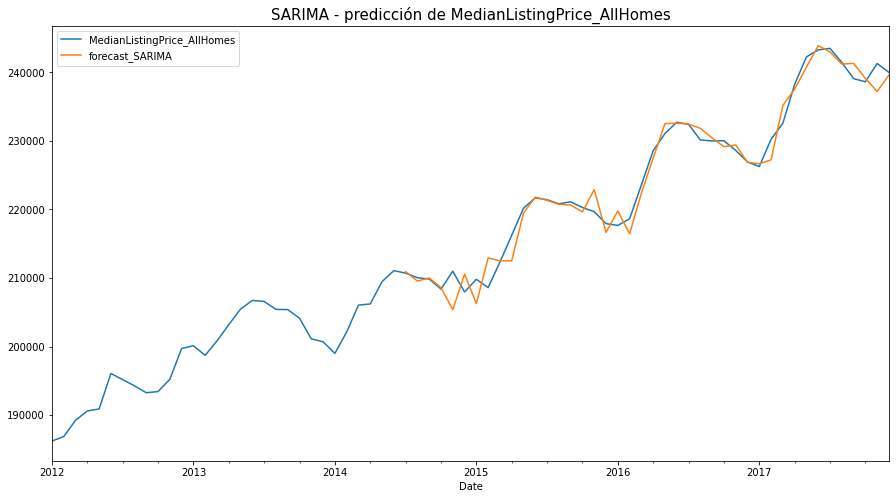

In [44]:
df_ts['forecast_SARIMA']=sarima_fit.predict(start = 30, end = 156)
df_ts[['MedianListingPrice_AllHomes','forecast_SARIMA']].plot(figsize=(15,8))
plt.title('SARIMA - predicción de MedianListingPrice_AllHomes', fontsize = 15)
plt.show()

In [45]:
from pandas.tseries.offsets import DateOffset

future_sarima = [df_ts.index[-1]+ DateOffset(months=x)for x in range(0,24)] # 2 años = 24 meses

In [46]:
future_df_SARIMA = pd.DataFrame(index=future_sarima[1:],columns=df_ts.columns)

In [47]:
future_df_SARIMA  = pd.concat([df_ts,future_df_SARIMA]) # Concatenamos los dos dataframes

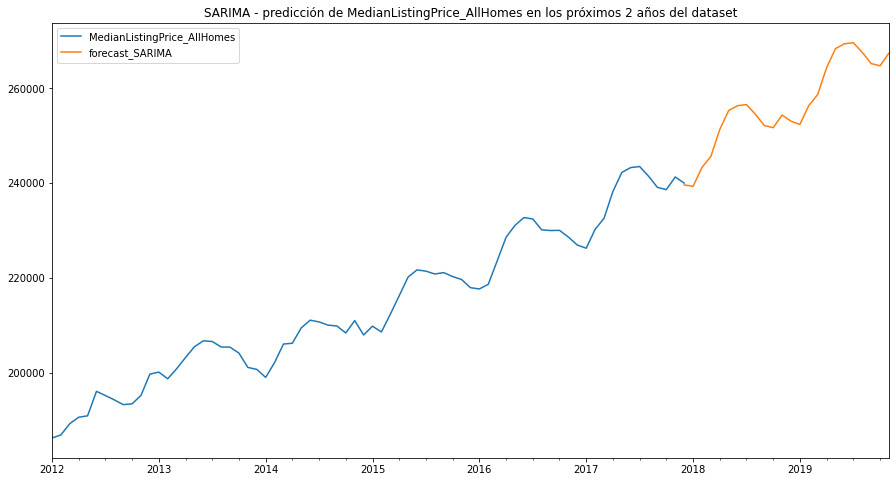

In [48]:
future_df_SARIMA ['forecast_SARIMA'] = sarima_fit.predict(start = 71, end = 156)  
future_df_SARIMA [['MedianListingPrice_AllHomes', 'forecast_SARIMA']].plot(figsize=(15, 8)) 
plt.title('SARIMA - predicción de MedianListingPrice_AllHomes en los próximos 2 años del dataset')
plt.show()

---

# PROPHET

In [49]:
data_month = data_drop.resample('M',on='Date').mean()
df_aux_prophet = data_month.reset_index()

df_ts_prophet = df_aux_prophet
df_ts_prophet['Date'] = df_aux['Date'].dt.to_period('W')
df_ts_prophet.set_index(['Date'],inplace = True)
df_ts_prophet.head()

,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts,Sales
Date,,,,
2012-01-30/2012-02-05,186217.29,170674.0,4143.204082,8.290139e+08
2012-02-27/2012-03-04,186866.94,169831.0,4202.816327,8.456398e+08
2012-03-26/2012-04-01,189243.83,170393.0,4706.687500,1.039651e+09
2012-04-30/2012-05-06,190602.20,171191.0,4788.916667,1.056214e+09
2012-05-28/2012-06-03,190900.50,171174.0,5135.531915,1.216632e+09


In [50]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [51]:
# Prophet trabaja la columna Date con el nombre 'ds' y la columna con las etiquetas con el nombre 'y'
df_ts_prophet = df_ts.drop(columns= ['Sale_Prices', 'Sale_Counts', 'Sales', 'Diff_1_AllHomes_Price', 'forecast_ARIMA', 'forecast_SARIMA'])
df_ts_prophet.reset_index(level= 0, inplace= True)
df_ts_prophet.rename(columns= {'Date': 'ds', 'MedianListingPrice_AllHomes' : 'y'}, inplace = True)

### Entrenamiento del modelo

In [52]:
# Instanciamos un modelo de Prophet

prophet = Prophet(yearly_seasonality= True, uncertainty_samples = 50, mcmc_samples=50, interval_width= 0.6)

# Entrenamos el modelo
prophet.fit(df_ts_prophet)

# Construimos un dataframe con los x valores futuros que querámos predecir. En este caso, 2 años.
future = prophet.make_future_dataframe(periods=(2*12), freq='M')

# Predecimos
forecast_prophet = prophet.predict(future)

12:11:43 - cmdstanpy - INFO - CmdStan installation c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
12:11:43 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
12:11:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                 

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


12:11:44 - cmdstanpy - INFO - CmdStan done processing.
12:11:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
12:11:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 divergent transiti

### - PREDICCIÓN

In [53]:
# yhat: valor pronosticado , (yhat_lower, yhat_upper): valores entre los que varia la prediccion, 
prophet_pred = prophet.predict(future)
prophet_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,187907.251972,182730.399472,187422.564134,187115.279524,188600.591595,-2851.178952,-4014.843022,-1590.807446,-2851.178952,-4014.843022,-1590.807446,0.0,0.0,0.0,185056.073020
1,2012-02-01,188639.922293,183330.273055,186569.559249,188048.963439,189260.802317,-3561.946478,-4187.863499,-2784.206134,-3561.946478,-4187.863499,-2784.206134,0.0,0.0,0.0,185077.975815
2,2012-03-01,189325.323561,185933.347484,190153.314541,188892.718647,189885.088065,-1258.900919,-2040.007924,-565.206145,-1258.900919,-2040.007924,-565.206145,0.0,0.0,0.0,188066.422642
3,2012-04-01,190090.224767,189584.101558,193883.837634,189581.502129,190619.593010,1595.224957,1078.981221,2258.742581,1595.224957,1078.981221,2258.742581,0.0,0.0,0.0,191685.449723
4,2012-05-01,190830.451740,192045.055932,195781.979152,190311.257349,191445.439888,2857.801802,1879.436105,3734.347550,2857.801802,1879.436105,3734.347550,0.0,0.0,0.0,193688.253542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2019-07-31,261354.421611,258731.643459,271374.370050,257067.455112,267618.835661,2838.481279,-43.768087,5310.706718,2838.481279,-43.768087,5310.706718,0.0,0.0,0.0,264192.902890
92,2019-08-31,262281.505244,257964.942218,268541.369346,257874.793137,269144.983788,338.191973,-3144.597680,2729.564677,338.191973,-3144.597680,2729.564677,0.0,0.0,0.0,262619.697217
93,2019-09-30,263178.682954,254386.037233,269950.209529,258324.647600,270531.652386,-2021.382299,-4911.814155,1232.265837,-2021.382299,-4911.814155,1232.265837,0.0,0.0,0.0,261157.300655
94,2019-10-31,264105.766588,258382.551359,274771.266035,258485.382648,271987.309282,1895.101819,-530.787079,4907.438442,1895.101819,-530.787079,4907.438442,0.0,0.0,0.0,266000.868407


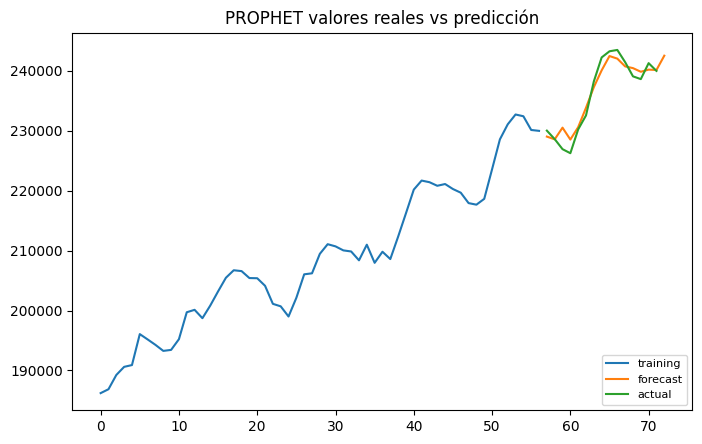

In [54]:
# Plot
plt.figure(figsize=(8,5), dpi=100)
plt.plot(train['MedianListingPrice_AllHomes'], label='training')
plt.plot(prophet_pred.yhat[57:73], label='forecast')
plt.plot(test['MedianListingPrice_AllHomes'], label='actual')


plt.title('PROPHET valores reales vs predicción')
plt.legend(loc='lower right', fontsize=8)
plt.show();

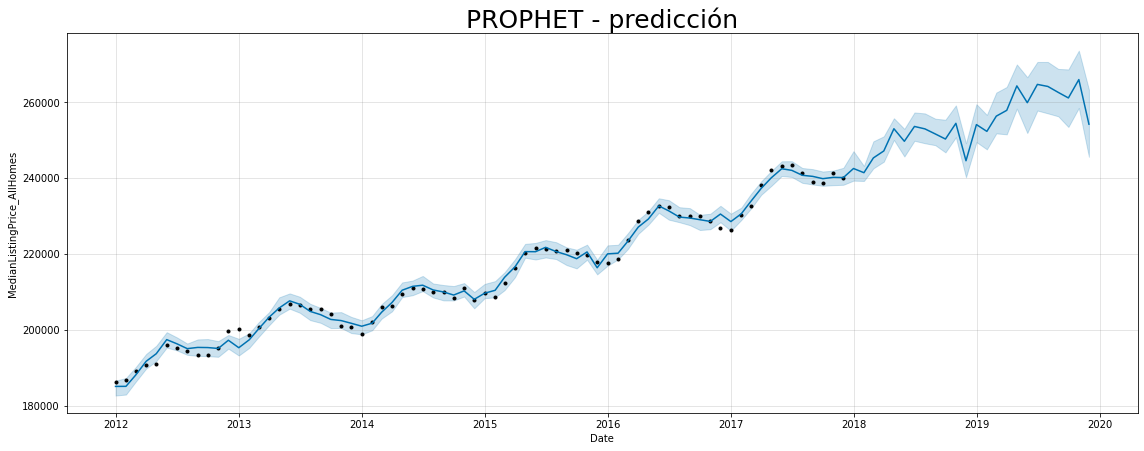

In [55]:
# plot forecasts

prophet.plot(forecast_prophet, xlabel='Date', ylabel='MedianListingPrice_AllHomes', figsize = (16,6))
plt.title('PROPHET - predicción', fontsize = 25)
plt.show()

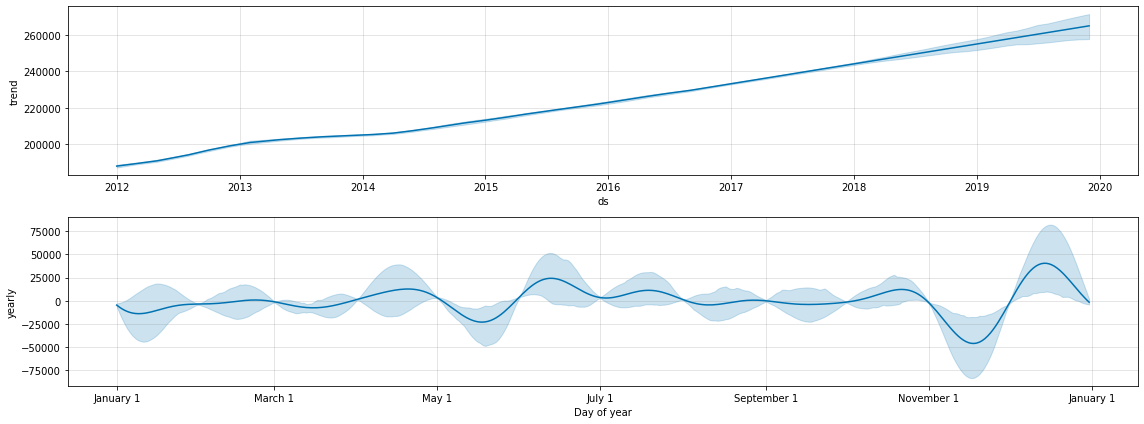

In [56]:
# Ploteamos los componentes de nuestra serie de tiempo

components = prophet.plot_components(forecast_prophet, figsize=(16,6))

### - Evaluación del modelo

In [57]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [58]:
df_cv = cross_validation(model=prophet, horizon= '365 days')

  0%|          | 0/4 [00:00<?, ?it/s]12:11:45 - cmdstanpy - INFO - CmdStan installation c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
12:11:45 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
12:11:45 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                 


12:11:45 - cmdstanpy - INFO - CmdStan done processing.
12:11:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
12:11:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (52.0%)
	Chain 2 had 8 divergent transitions (32.0%)
	Chain 3 had 4 divergent transitions (16.0%)
	Use function "diagnose()" to see further information.
 25%|██▌       | 1/4 [00:00<00:01,  2.47it/s]

12:11:45 - cmdstanpy - INFO - CmdStan installation c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
12:11:45 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
12:11:45 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   


12:11:45 - cmdstanpy - INFO - CmdStan done processing.
12:11:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
12:11:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 23 diver

12:11:45 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
12:11:45 - cmdstanpy - INFO - CmdStan start processing










chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                   


12:11:45 - cmdstanpy - INFO - CmdStan done processing.
12:11:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
12:11:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 22 divergent transit

12:11:46 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
12:11:46 - cmdstanpy - INFO - CmdStan start processing







chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:00 Sampling completed



chain 4 |██████████| 00:00 Sampling completed


12:11:46 - cmdstanpy - INFO - CmdStan done processing.
12:11:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
12:11:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transiti

In [59]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-07-01,218008.795188,214430.907836,221678.729035,221424.854167,2015-06-02 12:00:00
1,2015-08-01,217632.402533,214955.682408,220949.981972,220826.250000,2015-06-02 12:00:00
2,2015-09-01,219119.405468,216376.043886,222215.450086,221118.937500,2015-06-02 12:00:00
3,2015-10-01,218406.455019,214552.137963,222089.839510,220285.416667,2015-06-02 12:00:00
4,2015-11-01,221166.836851,216877.080150,224860.755799,219672.531250,2015-06-02 12:00:00
5,2015-12-01,215301.700173,211871.656354,218898.826763,217935.062500,2015-06-02 12:00:00
6,2016-01-01,219394.170284,214668.204070,222899.241498,217671.854167,2015-06-02 12:00:00
7,2016-02-01,219674.647055,214946.259734,224453.546909,218646.854167,2015-06-02 12:00:00
8,2016-03-01,223339.714972,217527.802303,228389.825209,223582.625000,2015-06-02 12:00:00
9,2016-04-01,224796.631189,218018.073864,230456.554569,228571.135417,2015-06-02 12:00:00


In [60]:
df_p = performance_metrics(df_cv)
df_p.describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,31,3.100000e+01,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,188 days 02:19:21.290322580,7.977645e+06,2707.976304,2291.651102,0.010048,0.009070,0.010025,0.762097
std,98 days 20:14:10.499994225,4.601868e+06,816.083761,746.308891,0.003348,0.003598,0.003314,0.207552
min,31 days 00:00:00,2.258395e+06,1502.795567,1105.736444,0.004811,0.004682,0.004832,0.375000
25%,106 days 00:00:00,4.551869e+06,2133.486317,1682.432273,0.007278,0.005903,0.007285,0.500000
50%,182 days 00:00:00,6.339416e+06,2517.819617,2251.576778,0.009619,0.008790,0.009621,0.750000
75%,258 days 12:00:00,1.136688e+07,3371.470272,2896.714497,0.012624,0.010347,0.012547,1.000000
max,365 days 00:00:00,1.924401e+07,4386.799523,3524.760105,0.015859,0.016645,0.015760,1.000000


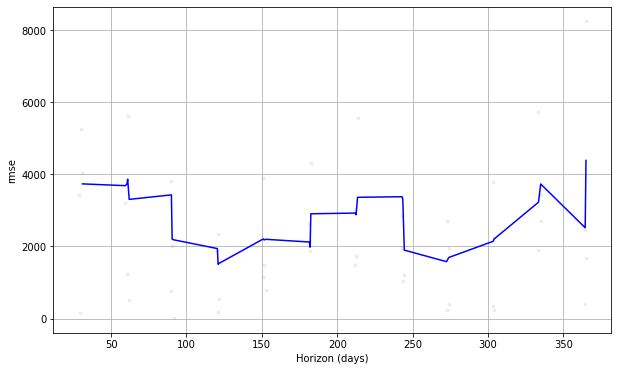

In [61]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [62]:
print('El RMSE es:', df_p.rmse.mean())

El RMSE es: 2707.9763039887766


In [63]:
df_p = performance_metrics(df_cv, rolling_window = 1)

In [64]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,8.422752e+06,2902.197776,2305.716771,0.010091,0.008531,0.010066,0.791667


---

# LSTM

In [65]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [66]:
df_LSTM = pd.DataFrame(df_ts['MedianListingPrice_AllHomes'])
df_LSTM

,MedianListingPrice_AllHomes
Date,
2012-01-01,186217.290000
2012-02-01,186866.940000
2012-03-01,189243.830000
2012-04-01,190602.200000
2012-05-01,190900.500000
...,...
2017-08-01,241460.319149
2017-09-01,239093.097826
2017-10-01,238629.880435


In [67]:
size = int(len(df_LSTM) * 0.8)

train_LSTM, test_LSTM = df_LSTM[0:size], df_LSTM[size:len(df_LSTM)]

In [68]:
# Escalar los datos a un rango entre (-1,1) para favorecer el proceso de cálculo de la red neuronal
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_LSTM)
scaled_train_data = scaler.transform(train_LSTM)
scaled_test_data = scaler.transform(test_LSTM)

In [69]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [70]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(200, input_shape=(n_input, n_features)))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mse', optimizer='adam')
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [71]:
LSTM_model.fit_generator(generator,epochs=25)

Epoch 1/25
45/45 [==============================] - 1s 3ms/step - loss: 0.0524
Epoch 2/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0390
Epoch 3/25
45/45 [==============================] - 0s 4ms/step - loss: 0.0291
Epoch 4/25
45/45 [==============================] - 0s 4ms/step - loss: 0.0258
Epoch 5/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0231
Epoch 6/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 7/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 8/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 9/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 10/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 11/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 12/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 13/25
45/45 [==============================

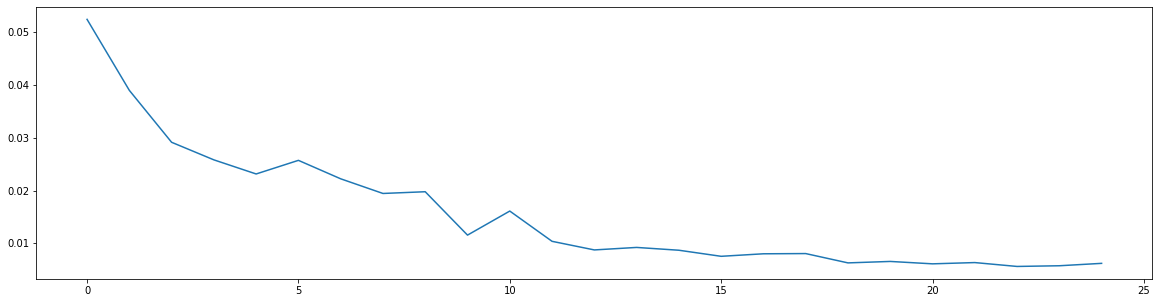

In [72]:
perdida_LSTM = LSTM_model.history.history['loss']
plt.figure(figsize=(20,5))
plt.xticks()
plt.plot(range(len(perdida_LSTM)),perdida_LSTM);

In [73]:
LSTM_prediccion_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test)):   
    LSTM_pred = LSTM_model.predict(current_batch)[0]
    LSTM_prediccion_scaled.append(LSTM_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[LSTM_pred]],axis=1)

1/1 [==============================] - 0s 15ms/step


In [74]:
LSTM_prediccion = scaler.inverse_transform(LSTM_prediccion_scaled)

In [75]:
MSE_LSTM = mean_squared_error(test_LSTM, LSTM_prediccion)
RMSE_LSTM = np.sqrt(MSE_LSTM)

print('MSE:', MSE_LSTM)
print('RMSE:', RMSE_LSTM)

MSE: 13592636.108141843
RMSE: 3686.819239960354


In [76]:
mape_LSTM = mape(test_LSTM, LSTM_prediccion) 
print('MAPE: ',round(mape_LSTM,2),'%')

MAPE:  MedianListingPrice_AllHomes    1.36
dtype: float64 %


In [77]:
index_date_test = df_ts.tail(15).index

In [78]:
df_pred_LSTM = pd.DataFrame(LSTM_prediccion, index= index_date_test)

In [79]:
df_pred_LSTM.rename(columns = {0:'LSTM_pred'}, inplace=True)

In [80]:
df_pred_LSTM

,LSTM_pred
Date,
2016-10-01,227819.977256
2016-11-01,227158.303791
2016-12-01,228052.824841
2017-01-01,230978.856245
2017-02-01,235425.799917
2017-03-01,239756.325341
2017-04-01,242250.699137
2017-05-01,242523.739792
2017-06-01,241185.711677


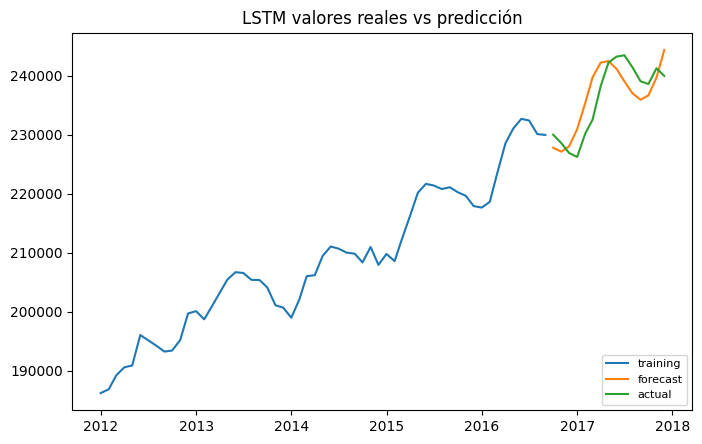

In [81]:
# Plot
plt.figure(figsize=(8,5), dpi=100)

plt.plot(train_LSTM, label='training')
plt.plot(df_pred_LSTM, label='forecast')
plt.plot(test_LSTM, label='actual')
plt.title('LSTM valores reales vs predicción')
plt.legend(loc='lower right', fontsize=8)
plt.show();

---

# - CONCLUSIÓN

- Al analizar los resultados de las métricas de evaluación y las gráficas de predicción se determina que los modelos SARIMA y Prophet son los que mejor ajustan al problema. Seleccionamos Prophet como modelo para nuestras predicciones.